# Song Genre Classification from Audio Data using ML

# Introduction

- Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.
- For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics.
- In this project we will classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves.

# Dataset Description

- We have the metadata about our tracks alongside the track metrics compiled by The Echo Nest.
- The dataset has downloaded from https://www.kaggle.com/aniruddhachoudhury/classify-song-genres-from-audio-data
- A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as danceability and cousticness on a scale from -1 to 1. 
- These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.
- Let's start the project by loading the data.

# 1. Importing the Dependencies

In [42]:
#Basic libraries
import pandas as pd 
import numpy as np
from scipy import stats

# Import Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly

# Classifiers
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier , VotingClassifier , RandomForestClassifier
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Model evaluation tools
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_score

# Data processing Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Other Libraries
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from collections import Counter

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 2. Data Loading & Analysis

In [2]:
import pandas as pd

# Read in track metadata with genre labels
tracks_data = pd.read_csv('fma-rock-vs-hiphop.csv')

# Read in track metrics with the features
echonest_metrics_data = pd.read_json('echonest-metrics.json', precise_float = True)

In [3]:
tracks_data.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [4]:
echonest_metrics_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [5]:
# Merge the relevant columns of tracks and echonest_metrics
echo_tracks_data = pd.merge(echonest_metrics_data, tracks_data[["track_id", "genre_top", "bit_rate"]], on = "track_id")

echo_tracks_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,bit_rate
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop,256000
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop,256000
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop,256000
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop,256000
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock,256000


In [6]:
# Lets try to find additional Information about the data
echo_tracks_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
 10  bit_rate          4802 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 450.2+ KB


**Observations:**
- It has been identified from the data that there are no NaN values in the data.

### Univariate Analysis

In [7]:
# On acousticness
print('Maximum value of acousticness :', echo_tracks_data['acousticness'].max())
print('Minimum value of acousticness :', echo_tracks_data['acousticness'].min())
print('Average value of acousticness :', echo_tracks_data['acousticness'].mean())

Maximum value of acousticness : 0.9957964501
Minimum value of acousticness : 9.491e-07
Average value of acousticness : 0.48705999919643883


In [8]:
print('Lable For Maximum value of acousticness :\n', echo_tracks_data[echo_tracks_data['acousticness'] == echo_tracks_data['acousticness'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of acousticness :\n', echo_tracks_data[echo_tracks_data['acousticness'] == echo_tracks_data['acousticness'].min()]['genre_top'].head(1))

Lable For Maximum value of acousticness :
 367    Rock
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of acousticness :
 3518    Rock
Name: genre_top, dtype: object


In [9]:
# On danceability
print('Maximum value of danceability :', echo_tracks_data['danceability'].max())
print('Minimum value of danceability :', echo_tracks_data['danceability'].min())
print('Average value of danceability :', echo_tracks_data['danceability'].mean())

Maximum value of danceability : 0.9618706942
Minimum value of danceability : 0.051307487
Average value of danceability : 0.4365556605918154


In [10]:
print('Lable For Maximum value of danceability :\n', echo_tracks_data[echo_tracks_data['danceability'] == echo_tracks_data['danceability'].max()]['genre_top'])

print('-' * 110)

print('Lable For Minimum value of danceability :\n', echo_tracks_data[echo_tracks_data['danceability'] == echo_tracks_data['danceability'].min()]['genre_top'])

Lable For Maximum value of danceability :
 4528    Hip-Hop
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of danceability :
 706    Rock
Name: genre_top, dtype: object


In [11]:
# On energy
print('Maximum value of energy :', echo_tracks_data['energy'].max())
print('Minimum value of energy :', echo_tracks_data['energy'].min())
print('Average value of energy :', echo_tracks_data['energy'].mean())

Maximum value of energy : 0.999767599
Minimum value of energy : 0.000278548
Average value of energy : 0.6251262115613291


In [12]:
print('Lable For Maximum value of energy :\n', echo_tracks_data[echo_tracks_data['energy'] == echo_tracks_data['energy'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of energy :\n', echo_tracks_data[echo_tracks_data['energy'] == echo_tracks_data['energy'].min()]['genre_top'].head(1))

Lable For Maximum value of energy :
 1326    Rock
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of energy :
 2151    Rock
Name: genre_top, dtype: object


In [13]:
# On instrumentalness
print('Maximum value of instrumentalness :', echo_tracks_data['instrumentalness'].max())
print('Minimum value of instrumentalness :', echo_tracks_data['instrumentalness'].min())
print('Average value of instrumentalness :', echo_tracks_data['instrumentalness'].mean())

Maximum value of instrumentalness : 0.9931342795
Minimum value of instrumentalness : 0.0
Average value of instrumentalness : 0.6040961494866335


In [14]:
print('Lable For Maximum value of instrumentalness :\n', echo_tracks_data[echo_tracks_data['instrumentalness'] == echo_tracks_data['instrumentalness'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of instrumentalness :\n', echo_tracks_data[echo_tracks_data['instrumentalness'] == echo_tracks_data['instrumentalness'].min()]['genre_top'].head(1))

Lable For Maximum value of instrumentalness :
 4699    Rock
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of instrumentalness :
 721    Rock
Name: genre_top, dtype: object


In [15]:
# On liveness
print('Maximum value of liveness :', echo_tracks_data['liveness'].max())
print('Minimum value of liveness :', echo_tracks_data['liveness'].min())
print('Average value of liveness :', echo_tracks_data['liveness'].mean())

Maximum value of liveness : 0.9713922939
Minimum value of liveness : 0.0252973415
Average value of liveness : 0.1879973580633279


In [16]:
print('Lable For Maximum value of liveness :\n', echo_tracks_data[echo_tracks_data['liveness'] == echo_tracks_data['liveness'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of liveness :\n', echo_tracks_data[echo_tracks_data['liveness'] == echo_tracks_data['liveness'].min()]['genre_top'].head(1))

Lable For Maximum value of liveness :
 3246    Rock
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of liveness :
 1413    Rock
Name: genre_top, dtype: object


In [17]:
# On speechiness
print('Maximum value of speechiness :', echo_tracks_data['speechiness'].max())
print('Minimum value of speechiness :', echo_tracks_data['speechiness'].min())
print('Average value of speechiness :', echo_tracks_data['speechiness'].mean())

Maximum value of speechiness : 0.9661774074
Minimum value of speechiness : 0.0232337297
Average value of speechiness : 0.10487721352194919


In [18]:
print('Lable For Maximum value of speechiness :\n', echo_tracks_data[echo_tracks_data['speechiness'] == echo_tracks_data['speechiness'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of speechiness :\n', echo_tracks_data[echo_tracks_data['speechiness'] == echo_tracks_data['speechiness'].min()]['genre_top'].head(1))

Lable For Maximum value of speechiness :
 1842    Hip-Hop
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of speechiness :
 1695    Hip-Hop
Name: genre_top, dtype: object


In [19]:
# On tempo
print('Maximum value of tempo :', echo_tracks_data['tempo'].max())
print('Minimum value of tempo :', echo_tracks_data['tempo'].min())
print('Average value of tempo :', echo_tracks_data['tempo'].mean())

Maximum value of tempo : 250.059
Minimum value of tempo : 29.093
Average value of tempo : 126.68794377342789


In [20]:
print('Lable For Maximum value of tempo :\n', echo_tracks_data[echo_tracks_data['tempo'] == echo_tracks_data['tempo'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of tempo :\n', echo_tracks_data[echo_tracks_data['tempo'] == echo_tracks_data['tempo'].min()]['genre_top'].head(1))

Lable For Maximum value of tempo :
 177    Rock
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of tempo :
 2234    Rock
Name: genre_top, dtype: object


In [21]:
# On valence
print('Maximum value of valence :', echo_tracks_data['valence'].max())
print('Minimum value of valence :', echo_tracks_data['valence'].min())
print('Average value of valence :', echo_tracks_data['valence'].mean())

Maximum value of valence : 0.9836492001
Minimum value of valence : 0.0143921742
Average value of valence : 0.45341338699214856


In [22]:
print('Lable For Maximum value of valence :\n', echo_tracks_data[echo_tracks_data['valence'] == echo_tracks_data['valence'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of valence :\n', echo_tracks_data[echo_tracks_data['valence'] == echo_tracks_data['valence'].min()]['genre_top'].head(1))

Lable For Maximum value of valence :
 2316    Rock
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of valence :
 4146    Rock
Name: genre_top, dtype: object


In [23]:
# On bit_rate
print('Maximum value of bit_rate :', echo_tracks_data['bit_rate'].max())
print('Minimum value of bit_rate :', echo_tracks_data['bit_rate'].min())
print('Average value of bit_rate :', echo_tracks_data['bit_rate'].mean())

Maximum value of bit_rate : 448000
Minimum value of bit_rate : -1
Average value of bit_rate : 246125.9925031237


In [24]:
print('Lable For Maximum value of bit_rate :\n', echo_tracks_data[echo_tracks_data['bit_rate'] == echo_tracks_data['bit_rate'].max()]['genre_top'].head(1))

print('-' * 110)

print('Lable For Minimum value of bit_rate :\n', echo_tracks_data[echo_tracks_data['bit_rate'] == echo_tracks_data['bit_rate'].min()]['genre_top'].head(1))

Lable For Maximum value of bit_rate :
 3238    Rock
Name: genre_top, dtype: object
--------------------------------------------------------------------------------------------------------------
Lable For Minimum value of bit_rate :
 1166    Rock
Name: genre_top, dtype: object


In [25]:
echo_tracks_data.columns

Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence',
       'genre_top', 'bit_rate'],
      dtype='object')

**Observations:**
- Nothing much sense of Labels and Trends can be analysed from the Univariate analysis of the Features.

## Bi-Variate Analysis

<AxesSubplot:>

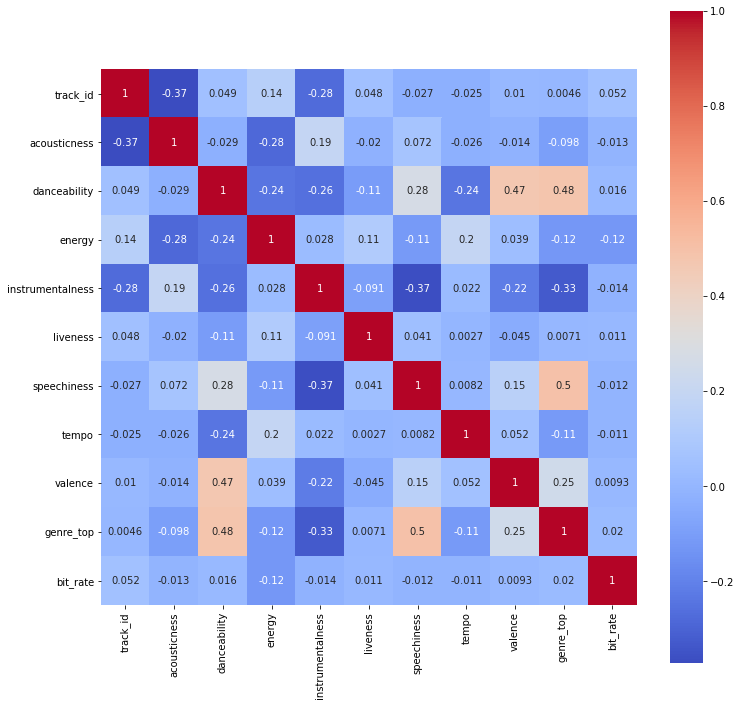

In [26]:
echo_tracks_data['genre_top'].replace('Rock', 0, inplace = True)
echo_tracks_data['genre_top'].replace('Hip-Hop', 1,inplace = True)

# Create a correlation matrix
corr_metrics = echo_tracks_data.corr()
fig = plt.figure(figsize = (12,12))
sns.heatmap(corr_metrics, square = True, cmap = "coolwarm", annot = True)

**Observations:**
- It can be observed that 'genre_top' has some co-relation with 'danceability' and 'speechiness'.
- But at the same time 'danceability' and 'speechiness' have some co-relation.

## Data Standardization

- As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. 
- Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called Principal Component Analysis (PCA).
- However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first Standardize our data.

In [27]:
# Define our features 
x = echo_tracks_data.drop(['genre_top','track_id'], axis = 1)

# Define our labels
y = echo_tracks_data['genre_top']

# Initializing StandardScaler
sc = StandardScaler()

# Scale the features and set the values to a new variable
x = sc.fit_transform(x)

## Applying PCA

- Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data.
- PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes.

In [28]:
# Initializing PCA
pca = PCA()

# Applying PCA
pca.fit(x)
exp_variance = pca.explained_variance_ratio_

Text(0.5, 0, 'Principal Components #')

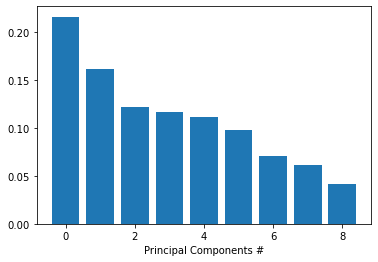

In [29]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(9), exp_variance)
ax.set_xlabel('Principal Components #')

### Visualization Using Scree Plot

- Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. 
- Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data.

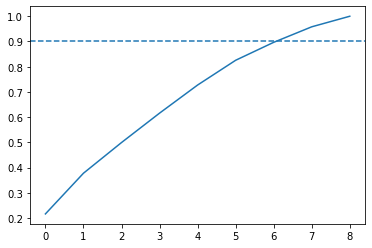

In [30]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(9), cum_exp_variance)
ax.axhline(y = 0.9, linestyle='--')
n_components = 6

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state = 10)

# Fitting the PCA 
pca.fit(x)

# Projecting them
pca_projection = pca.transform(x)

**Observations:**
- From the above graph it has cleared that about 6 Variables explains the 90% of Variance. So we can go for considering 6 Features to train our Model

In [35]:
# Getting seperated data with 1 and 0 status.
print('Total Number of Songs having genere Hip-Hop :', sum(echo_tracks_data.genre_top == 1))
print('Total Number of Songs having genere Rock    :', sum(echo_tracks_data.genre_top == 0))

Total Number of Songs having genere Hip-Hop : 910
Total Number of Songs having genere Rock    : 3892


**Observations:**
- Data is highly imbalanced. We need to balance it by using data balancing techniques.
- There are more chances that the model would Underfit.

# 3. Modeling

## Experiment 1: With Only Scaled Data

### Train - Test Splitting

In [36]:
# Split our data
x_train, x_test, y_train, y_test = train_test_split(pca_projection, y, random_state = 10)

### 1. KNN

In [44]:
# Model - 1 ----- KNN

# Tuning Hyper-Parameters
grid_parameters = {'n_neighbors' : [3,5,7,9,11,13], 'weights' : ['uniform', 'distance'], }

# Making Classifier Ready
model_1_knn = GridSearchCV(KNeighborsClassifier(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_1_knn.fit(x_train, y_train)

# Finding best_estimator
model_1_knn_best = model_1_knn.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished


In [45]:
# Predicting Model
y_pred_knn = model_1_knn_best.predict(x_test)

print ("Best Parameters For KNN : ",model_1_knn.best_params_)

Best Parameters For KNN :  {'n_neighbors': 9, 'weights': 'distance'}


In [46]:
# Evaluation

print("Training Accuracy For KNN :")
print(model_1_knn_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For KNN: ", accuracy_score(y_pred_knn , y_test))

print('-'*110)

print("\nAUC For KNN :")
print(roc_auc_score(y_test, y_pred_knn))

print('-'*110)

print("\nConfusion Matrix For KNN :")
print(confusion_matrix(y_test, y_pred_knn))

print('-'*110)
print("\nClassification Report For KNN :")
print(classification_report(y_test, y_pred_knn))

Training Accuracy For KNN :
1.0
--------------------------------------------------------------------------------------------------------------

Test Accuracy For KNN:  0.9134054954204829
--------------------------------------------------------------------------------------------------------------

AUC For KNN :
0.8254151799480199
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For KNN :
[[937  29]
 [ 75 160]]
--------------------------------------------------------------------------------------------------------------

Classification Report For KNN :
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       966
           1       0.85      0.68      0.75       235

    accuracy                           0.91      1201
   macro avg       0.89      0.83      0.85      1201
weighted avg       0.91      0.91      0.91      1201



### 2. Gaussian Naive Bayes

In [47]:
# Model - 2 ----- Gaussian NB

# Tuning Hyper-Parameters
grid_parameters = {}

# Making Classifier Ready
model_2_nb = GridSearchCV(GaussianNB(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_2_nb.fit(x_train, y_train)

# Finding best_estimator
model_2_nb_best = model_2_nb.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [48]:
# Predicting Model
y_pred_nb = model_2_nb_best.predict(x_test)

print ("Best Parameters For Naive Bayes : ",model_2_nb.best_params_)

Best Parameters For Naive Bayes :  {}


In [49]:
# Evaluation

print("Training Accuracy For Naive Bayes :")
print(model_2_nb_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Naive Bayes: ")
print(accuracy_score(y_pred_nb , y_test))
print('-'*110)

print("\nAUC For Naive Bayes :")
print(roc_auc_score(y_test, y_pred_nb))

print('-'*110)

print("\nConfusion Matrix For Naive Bayes :")
print(confusion_matrix(y_test, y_pred_nb))

print('-'*110)
print("\nClassification Report For Naive Bayes :")
print(classification_report(y_test, y_pred_nb))

Training Accuracy For Naive Bayes :
0.8855873368508748
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Naive Bayes: 
0.8742714404662781
--------------------------------------------------------------------------------------------------------------

AUC For Naive Bayes :
0.7560063433328927
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Naive Bayes :
[[918  48]
 [103 132]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Naive Bayes :
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       966
           1       0.73      0.56      0.64       235

    accuracy                           0.87      1201
   macro avg       0.82      0.76      0.78      1201
weighted avg       0.87      0.87  

### 3. Logistic Regression

In [50]:
# Model - 3 ----- Logistic Regression

# Tuning Hyper-Parameters
grid_parameters = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100]}

# Making Classifier Ready
model_3_lr = GridSearchCV(LogisticRegression(fit_intercept = True,), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_3_lr.fit(x_train, y_train)

# Finding best_estimator
model_3_lr_best = model_3_lr.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.9s finished


In [51]:
# Predicting Model
y_pred_lr = model_3_lr_best.predict(x_test)

print ("Best Parameters For Logistic Regression : ",model_3_lr.best_params_)

Best Parameters For Logistic Regression :  {'C': 0.1, 'penalty': 'l2'}


In [52]:
# Evaluation

print("Training Accuracy For Logistic Regression :")
print(model_3_lr_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Logistic Regression: ")
print(accuracy_score(y_pred_lr , y_test))

print('-'*110)

print("\nAUC For Logistic Regression :")
print(roc_auc_score(y_test, y_pred_lr))

print('-'*110)

print("\nConfusion Matrix For Logistic Regression :")
print(confusion_matrix(y_test, y_pred_lr))

print('-'*110)
print("\nClassification Report For Logistic Regression :")
print(classification_report(y_test, y_pred_lr))

Training Accuracy For Logistic Regression :
0.8753124132185504
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Logistic Regression: 
0.8776019983347211
--------------------------------------------------------------------------------------------------------------

AUC For Logistic Regression :
0.7516364917845028
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Logistic Regression :
[[926  40]
 [107 128]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Logistic Regression :
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       966
           1       0.76      0.54      0.64       235

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      

## 4. Support Vector Machines

In [54]:
# Model - 4 ----- SVM

# Tuning Hyper-Parameters
grid_parameters = {'C': [0.001,0.01,0.1,1,10], 'gamma': [0.001, 0.01, 1, 10, 100], 
                   'tol' :[0.01,0.1], 'degree' : [3,5]}

# Making Classifier Ready
model_4_svm = GridSearchCV(SVC(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_4_svm.fit(x_train, y_train)

# Finding best_estimator
model_4_svm_best = model_4_svm.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.8min finished


In [55]:
# Predicting Model
y_pred_svm = model_4_svm_best.predict(x_test)

print ("Best Parameters For SVMs : ",model_4_svm.best_params_)

Best Parameters For SVMs :  {'C': 1, 'degree': 3, 'gamma': 1, 'tol': 0.01}


In [56]:
# Evaluation

print("Training Accuracy For SVMs :")
print(model_4_svm_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy FOr SVMs :")
print(accuracy_score(y_pred_svm , y_test))

print('-'*110)

print("\nAUC For SVMs :")
print(roc_auc_score(y_test, y_pred_svm))

print('-'*110)

print("\nConfusion Matrix For SVMs :")
print(confusion_matrix(y_test, y_pred_svm))

print('-'*110)
print("\nClassification Report For SVMs :")
print(classification_report(y_test, y_pred_svm))

Training Accuracy For SVMs :
0.9583449041932797
--------------------------------------------------------------------------------------------------------------

Test Accuracy FOr SVMs :
0.9017485428809325
--------------------------------------------------------------------------------------------------------------

AUC For SVMs :
0.78596757852077
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For SVMs :
[[943  23]
 [ 95 140]]
--------------------------------------------------------------------------------------------------------------

Classification Report For SVMs :
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       966
           1       0.86      0.60      0.70       235

    accuracy                           0.90      1201
   macro avg       0.88      0.79      0.82      1201
weighted avg       0.90      0.90      0.89      1201



### 5. Random Forest Classifier

In [57]:
# Model - 5 ----- Random Forest

# Tuning Hyper-Parameters
grid_parameters = {'max_depth' : [3, 5, 7, 10, 13], 'n_estimators' : [100,150,200,300]}

# Making Classifier Ready
model_5_rf = GridSearchCV(RandomForestClassifier(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_5_rf.fit(x_train, y_train)

# Finding best_estimator
model_5_rf_best = model_5_rf.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   55.2s finished


In [58]:
# Predicting Model
y_pred_rf = model_5_rf_best.predict(x_test)

print ("Best Parameters For Random Forest Classifier : ",model_5_rf.best_params_)

Best Parameters For Random Forest Classifier :  {'max_depth': 10, 'n_estimators': 200}


In [60]:
# Evaluation

print("Training Accuracy For Random Forest Classifier :")
print(model_5_rf_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Random Forest Classifier :")
print(accuracy_score(y_pred_rf , y_test))

print('-'*110)

print("\nAUC For Random Forest Classifier :")
print(roc_auc_score(y_test, y_pred_rf))

print('-'*110)

print("\nConfusion Matrix For Random Forest Classifier :")
print(confusion_matrix(y_test, y_pred_rf))

print('-'*110)
print("\nClassification Report For Random Forest Classifier :")
print(classification_report(y_test, y_pred_rf))

Training Accuracy For Random Forest Classifier :
0.9613996112191058
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Random Forest Classifier :
0.9042464612822648
--------------------------------------------------------------------------------------------------------------

AUC For Random Forest Classifier :
0.8116712920135676
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Random Forest Classifier :
[[931  35]
 [ 80 155]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Random Forest Classifier :
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       966
           1       0.82      0.66      0.73       235

    accuracy                           0.90      1201
   macro avg       0.87 

### 6. XGBoosting

In [61]:
# Model - 6 ----- XGBClassifier

# Tuning Hyper-Parameters
grid_parameters = {'max_depth' : [3, 5, 7, 10], 'learning_rate' : [0.001, 0.01, 0.1, 1], 
                   'n_estimators' : [100,150,200,250,500]}

# Making Classifier Ready
model_6_xgb = GridSearchCV(XGBClassifier(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_6_xgb.fit(x_train, y_train)

# Finding best_estimator
model_6_xgb_best = model_6_xgb.best_estimator_

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 53.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 222.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 223.0min finished


In [62]:
# Predicting Model
y_pred_xgb = model_6_xgb_best.predict(x_test)

print ("Best Parameters For XGBoosting : ",model_6_xgb.best_params_)

Best Parameters For XGBoosting :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


In [63]:
# Evaluation

print("Training Accuracy For XGBoosting :")
print(model_6_xgb_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For XGBoosting :")
print(accuracy_score(y_pred_xgb , y_test))

print('-'*110)

print("\nAUC For XGBoosting :")
print(roc_auc_score(y_test, y_pred_xgb))

print('-'*110)

print("\nConfusion Matrix For XGBoosting :")
print(confusion_matrix(y_test, y_pred_xgb))

print('-'*110)
print("\nClassification Report For XGBoosting :")
print(classification_report(y_test, y_pred_xgb))

Training Accuracy For XGBoosting :
0.9300194390447099
--------------------------------------------------------------------------------------------------------------

Test Accuracy For XGBoosting :
0.9034138218151541
--------------------------------------------------------------------------------------------------------------

AUC For XGBoosting :
0.8159838773622307
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For XGBoosting :
[[927  39]
 [ 77 158]]
--------------------------------------------------------------------------------------------------------------

Classification Report For XGBoosting :
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       966
           1       0.80      0.67      0.73       235

    accuracy                           0.90      1201
   macro avg       0.86      0.82      0.84      1201
weighted avg       0.90      0.90      0

## Experiment 2: With Scaled Data + Down sampled Data

- We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. 
- Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance.

### Balancing of the Data

In [65]:
# Subset only the hip-hop tracks, and then only the rock tracks
hip_hop_songs = echo_tracks_data.loc[echo_tracks_data['genre_top'] == 1]

# sample the rocks songs to be the same number as there are hip-hop songs
rock_songs = echo_tracks_data.loc[echo_tracks_data["genre_top"] == 0].sample(len(hip_hop_songs), random_state = 10)

# concatenate the dataframes rock_only and hop_only
echo_tracks_data_balanced = pd.concat([rock_songs, hip_hop_songs])

### Train - Test Splitting

In [66]:
# The features, labels, and pca projection are created for the balanced dataframe
x = echo_tracks_data_balanced.drop(['genre_top', 'track_id'], axis = 1) 
y = echo_tracks_data_balanced['genre_top']
pca_projection = pca.fit_transform(sc.fit_transform(x))

# Redefine the train and test set with the pca_projection from the balanced data
x_train, x_test, y_train, y_test = train_test_split(pca_projection, y, random_state = 10, test_size = 0.25)

### 7. KNN

In [67]:
# Model - 7 ----- KNN

# Tuning Hyper-Parameters
grid_parameters = {'n_neighbors' : [3,5,7,9,11,13], 'weights' : ['uniform', 'distance'], }

# Making Classifier Ready
model_7_knn = GridSearchCV(KNeighborsClassifier(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_7_knn.fit(x_train, y_train)

# Finding best_estimator
model_7_knn_best = model_7_knn.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   34.5s finished


In [68]:
# Predicting Model
y_pred_knn = model_7_knn_best.predict(x_test)

print ("Best Parameters For KNN : ",model_7_knn.best_params_)

Best Parameters For KNN :  {'n_neighbors': 11, 'weights': 'distance'}


In [69]:
# Evaluation

print("Training Accuracy For KNN :")
print(model_7_knn_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For KNN: ", accuracy_score(y_pred_knn , y_test))

print('-'*110)

print("\nAUC For KNN :")
print(roc_auc_score(y_test, y_pred_knn))

print('-'*110)

print("\nConfusion Matrix For KNN :")
print(confusion_matrix(y_test, y_pred_knn))

print('-'*110)
print("\nClassification Report For KNN :")
print(classification_report(y_test, y_pred_knn))

Training Accuracy For KNN :
1.0
--------------------------------------------------------------------------------------------------------------

Test Accuracy For KNN:  0.8549450549450549
--------------------------------------------------------------------------------------------------------------

AUC For KNN :
0.8553140096618356
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For KNN :
[[200  25]
 [ 41 189]]
--------------------------------------------------------------------------------------------------------------

Classification Report For KNN :
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       225
           1       0.88      0.82      0.85       230

    accuracy                           0.85       455
   macro avg       0.86      0.86      0.85       455
weighted avg       0.86      0.85      0.85       455



### 8. Gaussian Naive Bayes

In [70]:
# Model - 8 ----- Gaussian NB

# Tuning Hyper-Parameters
grid_parameters = {}

# Making Classifier Ready
model_8_nb = GridSearchCV(GaussianNB(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_8_nb.fit(x_train, y_train)

# Finding best_estimator
model_8_nb_best = model_8_nb.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [71]:
# Predicting Model
y_pred_nb = model_8_nb_best.predict(x_test)

print ("Best Parameters For Naive Bayes : ",model_8_nb.best_params_)

Best Parameters For Naive Bayes :  {}


In [72]:
# Evaluation

print("Training Accuracy For Naive Bayes :")
print(model_8_nb_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Naive Bayes: ")
print(accuracy_score(y_pred_nb , y_test))
print('-'*110)

print("\nAUC For Naive Bayes :")
print(roc_auc_score(y_test, y_pred_nb))

print('-'*110)

print("\nConfusion Matrix For Naive Bayes :")
print(confusion_matrix(y_test, y_pred_nb))

print('-'*110)
print("\nClassification Report For Naive Bayes :")
print(classification_report(y_test, y_pred_nb))

Training Accuracy For Naive Bayes :
0.8300366300366301
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Naive Bayes: 
0.843956043956044
--------------------------------------------------------------------------------------------------------------

AUC For Naive Bayes :
0.8442995169082126
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Naive Bayes :
[[197  28]
 [ 43 187]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Naive Bayes :
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       225
           1       0.87      0.81      0.84       230

    accuracy                           0.84       455
   macro avg       0.85      0.84      0.84       455
weighted avg       0.85      0.84   

### 9. Logistic Regression

In [73]:
# Model - 9 ----- Logistic Regression

# Tuning Hyper-Parameters
grid_parameters = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100]}

# Making Classifier Ready
model_9_lr = GridSearchCV(LogisticRegression(fit_intercept = True,), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_9_lr.fit(x_train, y_train)

# Finding best_estimator
model_9_lr_best = model_9_lr.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    1.3s finished


In [74]:
# Predicting Model
y_pred_lr = model_9_lr_best.predict(x_test)

print ("Best Parameters For Logistic Regression : ",model_9_lr.best_params_)

Best Parameters For Logistic Regression :  {'C': 0.1, 'penalty': 'l2'}


In [75]:
# Evaluation

print("Training Accuracy For Logistic Regression :")
print(model_9_lr_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Logistic Regression: ")
print(accuracy_score(y_pred_lr , y_test))

print('-'*110)

print("\nAUC For Logistic Regression :")
print(roc_auc_score(y_test, y_pred_lr))

print('-'*110)

print("\nConfusion Matrix For Logistic Regression :")
print(confusion_matrix(y_test, y_pred_lr))

print('-'*110)
print("\nClassification Report For Logistic Regression :")
print(classification_report(y_test, y_pred_lr))

Training Accuracy For Logistic Regression :
0.8227106227106227
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Logistic Regression: 
0.810989010989011
--------------------------------------------------------------------------------------------------------------

AUC For Logistic Regression :
0.8113043478260868
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Logistic Regression :
[[189  36]
 [ 50 180]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Logistic Regression :
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       225
           1       0.83      0.78      0.81       230

    accuracy                           0.81       455
   macro avg       0.81      0.81      0.81       

### 10. Support Vector Machines

In [76]:
# Model - 10 ----- SVM

# Tuning Hyper-Parameters
grid_parameters = {'C': [0.001,0.01,0.1,1,10], 'gamma': [0.001, 0.01, 1, 10, 100], 
                   'tol' :[0.01,0.1], 'degree' : [3,5]}

# Making Classifier Ready
model_10_svm = GridSearchCV(SVC(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_10_svm.fit(x_train, y_train)

# Finding best_estimator
model_10_svm_best = model_10_svm.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.1s finished


In [77]:
# Predicting Model
y_pred_svm = model_10_svm_best.predict(x_test)

print ("Best Parameters For SVMs : ",model_10_svm.best_params_)

Best Parameters For SVMs :  {'C': 10, 'degree': 3, 'gamma': 0.01, 'tol': 0.1}


In [78]:
# Evaluation

print("Training Accuracy For SVMs :")
print(model_10_svm_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy FOr SVMs :")
print(accuracy_score(y_pred_svm , y_test))

print('-'*110)

print("\nAUC For SVMs :")
print(roc_auc_score(y_test, y_pred_svm))

print('-'*110)

print("\nConfusion Matrix For SVMs :")
print(confusion_matrix(y_test, y_pred_svm))

print('-'*110)
print("\nClassification Report For SVMs :")
print(classification_report(y_test, y_pred_svm))

Training Accuracy For SVMs :
0.8586080586080586
--------------------------------------------------------------------------------------------------------------

Test Accuracy FOr SVMs :
0.843956043956044
--------------------------------------------------------------------------------------------------------------

AUC For SVMs :
0.8441545893719807
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For SVMs :
[[194  31]
 [ 40 190]]
--------------------------------------------------------------------------------------------------------------

Classification Report For SVMs :
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       225
           1       0.86      0.83      0.84       230

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455



### 11. Random Forest Classifier

In [79]:
# Model - 11 ----- Random Forest

# Tuning Hyper-Parameters
grid_parameters = {'max_depth' : [3, 5, 7, 10, 13], 'n_estimators' : [100,150,200,300]}

# Making Classifier Ready
model_11_rf = GridSearchCV(RandomForestClassifier(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_11_rf.fit(x_train, y_train)

# Finding best_estimator
model_11_rf_best = model_11_rf.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.1s finished


In [80]:
# Predicting Model
y_pred_rf = model_11_rf_best.predict(x_test)

print ("Best Parameters For Random Forest Classifier : ",model_11_rf.best_params_)

Best Parameters For Random Forest Classifier :  {'max_depth': 13, 'n_estimators': 150}


In [81]:
# Evaluation

print("Training Accuracy For Random Forest Classifier :")
print(model_11_rf_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Random Forest Classifier :")
print(accuracy_score(y_pred_rf , y_test))

print('-'*110)

print("\nAUC For Random Forest Classifier :")
print(roc_auc_score(y_test, y_pred_rf))

print('-'*110)

print("\nConfusion Matrix For Random Forest Classifier :")
print(confusion_matrix(y_test, y_pred_rf))

print('-'*110)
print("\nClassification Report For Random Forest Classifier :")
print(classification_report(y_test, y_pred_rf))

Training Accuracy For Random Forest Classifier :
0.9978021978021978
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Random Forest Classifier :
0.8483516483516483
--------------------------------------------------------------------------------------------------------------

AUC For Random Forest Classifier :
0.8486473429951691
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Random Forest Classifier :
[[197  28]
 [ 41 189]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Random Forest Classifier :
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       225
           1       0.87      0.82      0.85       230

    accuracy                           0.85       455
   macro avg       0.85 

## Experiment 3: With Sclaed + Up Sampled Data

### Balancing

In [82]:
# Getting seperated data with 1 and 0 status.
df_majority = echo_tracks_data[echo_tracks_data.genre_top == 0]
df_minority = echo_tracks_data[echo_tracks_data.genre_top == 1]

# Here we are upsampling the Minority Class Data Points. 
# i.e. We will get equal amount of datapoint as Majority class from Minority class

df_minority_upsampled = resample(df_minority, replace = True, n_samples = 3892, random_state = 1)
echo_tracks_data_upsampled = pd.concat([df_majority, df_minority_upsampled])

print("Upsampled data:- \n", echo_tracks_data_upsampled.genre_top.value_counts())

Upsampled data:- 
 1    3892
0    3892
Name: genre_top, dtype: int64


### Train-Test Splitting

In [83]:
# The features, labels, and pca projection are created for the balanced dataframe
x = echo_tracks_data_upsampled.drop(['genre_top', 'track_id'], axis = 1) 
y = echo_tracks_data_upsampled['genre_top']
pca_projection = pca.fit_transform(sc.fit_transform(x))

# Redefine the train and test set with the pca_projection from the balanced data
x_train, x_test, y_train, y_test = train_test_split(pca_projection, y, random_state = 10, test_size = 0.25)

### 13. KNN

In [84]:
# Model - 13 ----- KNN

# Tuning Hyper-Parameters
grid_parameters = {'n_neighbors' : [3,5,7,9,11,13], 'weights' : ['uniform', 'distance'], }

# Making Classifier Ready
model_13_knn = GridSearchCV(KNeighborsClassifier(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_13_knn.fit(x_train, y_train)

# Finding best_estimator
model_13_knn_best = model_13_knn.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.4s finished


In [85]:
# Predicting Model
y_pred_knn = model_13_knn_best.predict(x_test)

print ("Best Parameters For KNN : ",model_13_knn.best_params_)

Best Parameters For KNN :  {'n_neighbors': 13, 'weights': 'distance'}


In [86]:
# Evaluation

print("Training Accuracy For KNN :")
print(model_13_knn_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For KNN: ", accuracy_score(y_pred_knn , y_test))

print('-'*110)

print("\nAUC For KNN :")
print(roc_auc_score(y_test, y_pred_knn))

print('-'*110)

print("\nConfusion Matrix For KNN :")
print(confusion_matrix(y_test, y_pred_knn))

print('-'*110)
print("\nClassification Report For KNN :")
print(classification_report(y_test, y_pred_knn))

Training Accuracy For KNN :
1.0
--------------------------------------------------------------------------------------------------------------

Test Accuracy For KNN:  0.9244604316546763
--------------------------------------------------------------------------------------------------------------

AUC For KNN :
0.9259453781512605
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For KNN :
[[852 142]
 [  5 947]]
--------------------------------------------------------------------------------------------------------------

Classification Report For KNN :
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       994
           1       0.87      0.99      0.93       952

    accuracy                           0.92      1946
   macro avg       0.93      0.93      0.92      1946
weighted avg       0.93      0.92      0.92      1946



### 14. Gaussian Naive Bayes

In [87]:
# Model - 14 ----- Gaussian NB

# Tuning Hyper-Parameters
grid_parameters = {}

# Making Classifier Ready
model_14_nb = GridSearchCV(GaussianNB(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_14_nb.fit(x_train, y_train)

# Finding best_estimator
model_14_nb_best = model_14_nb.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [88]:
# Predicting Model
y_pred_nb = model_14_nb_best.predict(x_test)

print ("Best Parameters For Naive Bayes : ",model_14_nb.best_params_)

Best Parameters For Naive Bayes :  {}


In [89]:
# Evaluation

print("Training Accuracy For Naive Bayes :")
print(model_14_nb_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Naive Bayes: ")
print(accuracy_score(y_pred_nb , y_test))
print('-'*110)

print("\nAUC For Naive Bayes :")
print(roc_auc_score(y_test, y_pred_nb))

print('-'*110)

print("\nConfusion Matrix For Naive Bayes :")
print(confusion_matrix(y_test, y_pred_nb))

print('-'*110)
print("\nClassification Report For Naive Bayes :")
print(classification_report(y_test, y_pred_nb))

Training Accuracy For Naive Bayes :
0.8230558410414526
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Naive Bayes: 
0.8355601233299075
--------------------------------------------------------------------------------------------------------------

AUC For Naive Bayes :
0.8353281453426441
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Naive Bayes :
[[841 153]
 [167 785]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Naive Bayes :
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       994
           1       0.84      0.82      0.83       952

    accuracy                           0.84      1946
   macro avg       0.84      0.84      0.84      1946
weighted avg       0.84      0.84  

### 15. Logistic Regression

In [90]:
# Model - 15 ----- Logistic Regression

# Tuning Hyper-Parameters
grid_parameters = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100]}

# Making Classifier Ready
model_15_lr = GridSearchCV(LogisticRegression(fit_intercept = True,), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_15_lr.fit(x_train, y_train)

# Finding best_estimator
model_15_lr_best = model_15_lr.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    0.2s finished


In [91]:
# Predicting Model
y_pred_lr = model_15_lr_best.predict(x_test)

print ("Best Parameters For Logistic Regression : ",model_15_lr.best_params_)

Best Parameters For Logistic Regression :  {'C': 0.1, 'penalty': 'l2'}


In [92]:
# Evaluation

print("Training Accuracy For Logistic Regression :")
print(model_15_lr_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Logistic Regression: ")
print(accuracy_score(y_pred_lr , y_test))

print('-'*110)

print("\nAUC For Logistic Regression :")
print(roc_auc_score(y_test, y_pred_lr))

print('-'*110)

print("\nConfusion Matrix For Logistic Regression :")
print(confusion_matrix(y_test, y_pred_lr))

print('-'*110)
print("\nClassification Report For Logistic Regression :")
print(classification_report(y_test, y_pred_lr))

Training Accuracy For Logistic Regression :
0.8084960602946214
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Logistic Regression: 
0.81551901336074
--------------------------------------------------------------------------------------------------------------

AUC For Logistic Regression :
0.8154885193514025
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Logistic Regression :
[[812 182]
 [177 775]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Logistic Regression :
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       994
           1       0.81      0.81      0.81       952

    accuracy                           0.82      1946
   macro avg       0.82      0.82      0.82      19

### 16. Support Vector Machines

In [93]:
# Model - 16 ----- SVM

# Tuning Hyper-Parameters
grid_parameters = {'C': [0.001,0.01,0.1,1,10], 'gamma': [0.001, 0.01, 1, 10, 100], 
                   'tol' :[0.01,0.1], 'degree' : [3,5]}

# Making Classifier Ready
model_16_svm = GridSearchCV(SVC(), grid_parameters, verbose = 1, cv = 5, n_jobs = -1)

# Training The Model
model_16_svm.fit(x_train, y_train)

# Finding best_estimator
model_16_svm_best = model_16_svm.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.9min finished


In [94]:
# Predicting Model
y_pred_svm = model_16_svm_best.predict(x_test)

print ("Best Parameters For SVMs : ",model_16_svm.best_params_)

Best Parameters For SVMs :  {'C': 10, 'degree': 3, 'gamma': 10, 'tol': 0.01}


In [95]:
# Evaluation

print("Training Accuracy For SVMs :")
print(model_16_svm_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy FOr SVMs :")
print(accuracy_score(y_pred_svm , y_test))

print('-'*110)

print("\nAUC For SVMs :")
print(roc_auc_score(y_test, y_pred_svm))

print('-'*110)

print("\nConfusion Matrix For SVMs :")
print(confusion_matrix(y_test, y_pred_svm))

print('-'*110)
print("\nClassification Report For SVMs :")
print(classification_report(y_test, y_pred_svm))

Training Accuracy For SVMs :
1.0
--------------------------------------------------------------------------------------------------------------

Test Accuracy FOr SVMs :
0.9886947584789312
--------------------------------------------------------------------------------------------------------------

AUC For SVMs :
0.9884675701266423
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For SVMs :
[[993   1]
 [ 21 931]]
--------------------------------------------------------------------------------------------------------------

Classification Report For SVMs :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       994
           1       1.00      0.98      0.99       952

    accuracy                           0.99      1946
   macro avg       0.99      0.99      0.99      1946
weighted avg       0.99      0.99      0.99      1946



### 17. Random Forest Classifier

In [96]:
# Model - 17 ----- Random Forest

# Tuning Hyper-Parameters
grid_parameters = {'max_depth' : [3, 5, 7, 10, 13], 'n_estimators' : [100,150,200,300]}

# Making Classifier Ready
model_17_rf = GridSearchCV(RandomForestClassifier(), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_17_rf.fit(x_train, y_train)

# Finding best_estimator
model_17_rf_best = model_17_rf.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   31.3s finished


In [97]:
# Predicting Model
y_pred_rf = model_17_rf_best.predict(x_test)

print ("Best Parameters For Random Forest Classifier : ",model_17_rf.best_params_)

Best Parameters For Random Forest Classifier :  {'max_depth': 13, 'n_estimators': 150}


In [98]:
# Evaluation

print("Training Accuracy For Random Forest Classifier :")
print(model_17_rf_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For Random Forest Classifier :")
print(accuracy_score(y_pred_rf , y_test))

print('-'*110)

print("\nAUC For Random Forest Classifier :")
print(roc_auc_score(y_test, y_pred_rf))

print('-'*110)

print("\nConfusion Matrix For Random Forest Classifier :")
print(confusion_matrix(y_test, y_pred_rf))

print('-'*110)
print("\nClassification Report For Random Forest Classifier :")
print(classification_report(y_test, y_pred_rf))

Training Accuracy For Random Forest Classifier :
0.9958890030832477
--------------------------------------------------------------------------------------------------------------

Test Accuracy For Random Forest Classifier :
0.959917780061665
--------------------------------------------------------------------------------------------------------------

AUC For Random Forest Classifier :
0.9604760918451888
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For Random Forest Classifier :
[[929  65]
 [ 13 939]]
--------------------------------------------------------------------------------------------------------------

Classification Report For Random Forest Classifier :
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       994
           1       0.94      0.99      0.96       952

    accuracy                           0.96      1946
   macro avg       0.96  

### 18. XGBoosted Classifier

In [100]:
# Model - 18 ----- XGBClassifier

# Tuning Hyper-Parameters
grid_parameters = {'max_depth' : [3, 5, 7, 10], 'learning_rate' : [0.001, 0.01, 0.1, 1], 
                   'n_estimators' : [100,150,200,250,500]}

# Making Classifier Ready
model_18_xgb = GridSearchCV(XGBClassifier(objective = 'binary:hinge'), grid_parameters, verbose = 1, cv = 3, n_jobs = -1)

# Training The Model
model_18_xgb.fit(x_train, y_train)

# Finding best_estimator
model_18_xgb_best = model_18_xgb.best_estimator_

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  6.8min finished


In [101]:
# Predicting Model
y_pred_xgb = model_18_xgb_best.predict(x_test)

print ("Best Parameters For XGBoosting : ",model_18_xgb.best_params_)

Best Parameters For XGBoosting :  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [102]:
# Evaluation

print("Training Accuracy For XGBoosting :")
print(model_18_xgb_best.score(x_train, y_train))

print('-'*110)

print("\nTest Accuracy For XGBoosting :")
print(accuracy_score(y_pred_xgb , y_test))

print('-'*110)

print("\nAUC For XGBoosting :")
print(roc_auc_score(y_test, y_pred_xgb))

print('-'*110)

print("\nConfusion Matrix For XGBoosting :")
print(confusion_matrix(y_test, y_pred_xgb))

print('-'*110)
print("\nClassification Report For XGBoosting :")
print(classification_report(y_test, y_pred_xgb))

Training Accuracy For XGBoosting :
0.9981157930798219
--------------------------------------------------------------------------------------------------------------

Test Accuracy For XGBoosting :
0.9640287769784173
--------------------------------------------------------------------------------------------------------------

AUC For XGBoosting :
0.9645224286897858
--------------------------------------------------------------------------------------------------------------

Confusion Matrix For XGBoosting :
[[936  58]
 [ 12 940]]
--------------------------------------------------------------------------------------------------------------

Classification Report For XGBoosting :
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       994
           1       0.94      0.99      0.96       952

    accuracy                           0.96      1946
   macro avg       0.96      0.96      0.96      1946
weighted avg       0.97      0.96      0

# 4. Model Comparisons

### Model Comparison With Only Scaled Data

In [106]:
print('Accuracy by Using hypertuned KNN                       : 91.34%')
print('Accuracy by Using hypertuned Gaussian NB               : 87.42%')
print('Accuracy by Using hypertuned Logistic Regression       : 87.76%')
print('Accuracy by Using hypertuned SVM                       : 90.17%')
print('Accuracy by Using hypertuned Random Forest             : 90.42%')
print('Accuracy by Using hypertuned XGB Classifier (Logistic) : 90.34%')

Accuracy by Using hypertuned KNN                       : 91.34%
Accuracy by Using hypertuned Gaussian NB               : 87.42%
Accuracy by Using hypertuned Logistic Regression       : 87.76%
Accuracy by Using hypertuned SVM                       : 90.17%
Accuracy by Using hypertuned Random Forest             : 90.42%
Accuracy by Using hypertuned XGB Classifier (Logistic) : 90.34%


### Model Comparison With Sclaed + Down Sampled Data

In [107]:
print('Accuracy by Using hypertuned KNN                       : 85.49%')
print('Accuracy by Using hypertuned Gaussian NB               : 84.39%')
print('Accuracy by Using hypertuned Logistic Regression       : 81.09%')
print('Accuracy by Using hypertuned SVM                       : 84.39%')
print('Accuracy by Using hypertuned Random Forest             : 84.83%')

Accuracy by Using hypertuned KNN                       : 85.49%
Accuracy by Using hypertuned Gaussian NB               : 84.39%
Accuracy by Using hypertuned Logistic Regression       : 81.09%
Accuracy by Using hypertuned SVM                       : 84.39%
Accuracy by Using hypertuned Random Forest             : 84.83%


### Model Comparison With Sclaed + Up Sampled Data

In [108]:
print('Accuracy by Using hypertuned KNN                       : 81.06%')
print('Accuracy by Using hypertuned Gaussian NB               : 83.55%')
print('Accuracy by Using hypertuned Logistic Regression       : 81.55%')
print('Accuracy by Using hypertuned SVM                       : 98.86%')
print('Accuracy by Using hypertuned Random Forest             : 95.99%')
print('Accuracy by Using hypertuned XGB Classifier (Hinge)    : 96.40%')

Accuracy by Using hypertuned KNN                       : 81.06%
Accuracy by Using hypertuned Gaussian NB               : 83.55%
Accuracy by Using hypertuned Logistic Regression       : 81.55%
Accuracy by Using hypertuned SVM                       : 98.86%
Accuracy by Using hypertuned Random Forest             : 95.99%
Accuracy by Using hypertuned XGB Classifier (Hinge)    : 96.40%


# End Results

- After all the possible experiments Maximum accuracy of 98.86% is achieved by using SVM and by making data balanced as Up Sampling.
- So, SVMs would accurately classify the Genre of the Songs if audio features have given.
- Surprisingly XGB Classifier does not give the accuracy better than SVM.

# End of File